# Домашнее задание к Уроку 2

### Код из урока

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\vladuz\AppData\Local\Temp\ipykernel_5472\2296537027.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 51.2 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 6min 49s


А теперь в 3 строчки обучим нашу модель

In [11]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [12]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [13]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 1min 16s


In [14]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [15]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(2, 0.061686438),
 (15, 0.3325891),
 (16, 0.0840265),
 (21, 0.3660098),
 (22, 0.13790147)]

In [16]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: женщина мужчина убийство ребёнок страдать nn обвинение
topic_1: гражданин запустить год фронт население народный это
topic_2: фонд напомнить температура обращение градус кровь брюссель
topic_3: ракета погибнуть огонь иран сша азия американский
topic_4: пациент фестиваль лечение проживать гость ii орден
topic_5: проверка форум предмет выделить московский девочка москва
topic_6: мозг товар организм след теория мышь кровь
topic_7: военный млрд управление год рубль станция россия
topic_8: поверхность вицепремьер снять параметр пресссекретарить песок миллиардер
topic_9: планета прогноз фотография климат продолжительность диск популярный
topic_10: министерство км высота энергия агентство падение применение
topic_11: белый отреагировать сердце представляться news уильям педагог
topic_12: китай остров китайский японский рейтинг япония место
topic_13: россия президент российский nn это путин глава
topic_14: обнаружить взрыв задержать операция космос район результат
topic_15: миссия эки

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [17]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [18]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017340,0.315079,0.0,0.0,0.0,0.032137,0.071139,0.000000,0.0,0.048109
1,4896,0.133924,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.229451,0.000000,0.0,0.000000
2,4897,0.000000,0.0,0.061599,0.0,0.0,0.0,0.0,0.0,0.0,...,0.332341,0.084060,0.0,0.0,0.0,0.000000,0.366057,0.138157,0.0,0.000000
3,4898,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.019042,0.281352,0.644202,0.0,0.000000
4,4899,0.000000,0.0,0.134576,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [21]:
doc_dict[293622]

array([0.13524039, 0.        , 0.04303512, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.20455131, 0.        ,
       0.        , 0.15519053, 0.        , 0.        , 0.        ,
       0.17282437, 0.        , 0.25243995, 0.02578976, 0.        ])

In [22]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [23]:
get_user_embedding(user_articles_list)

array([0.08251774, 0.00548004, 0.        , 0.0045667 , 0.        ,
       0.        , 0.00269866, 0.03448518, 0.00577814, 0.        ,
       0.        , 0.0023599 , 0.        , 0.20656086, 0.02342323,
       0.04868878, 0.20550054, 0.        , 0.00266502, 0.0017138 ,
       0.03838269, 0.00182501, 0.22625219, 0.00246727, 0.09389655])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [24]:
#users['articles'].iloc[33]

In [25]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [26]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.050440,0.004040,0.007173,0.002411,0.002102,0.019720,0.000000,0.015047,0.0,...,0.016073,0.263080,0.0,0.0,0.015223,0.125703,0.000000,0.199606,0.017715,0.015022
1,u108690,0.051272,0.005932,0.000000,0.000000,0.000000,0.007467,0.002525,0.015000,0.0,...,0.000000,0.156730,0.0,0.0,0.003872,0.046497,0.005738,0.333120,0.003959,0.092174
2,u108339,0.044234,0.006937,0.018059,0.015552,0.000000,0.005983,0.000000,0.041553,0.0,...,0.002766,0.267651,0.0,0.0,0.000000,0.053272,0.002246,0.254201,0.002450,0.008671


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [27]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [28]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.050440,0.004040,0.007173,0.002411,0.002102,0.019720,0.000000,0.015047,0.0,...,0.263080,0.0,0.0,0.015223,0.125703,0.000000,0.199606,0.017715,0.015022,0
1,u108690,0.051272,0.005932,0.000000,0.000000,0.000000,0.007467,0.002525,0.015000,0.0,...,0.156730,0.0,0.0,0.003872,0.046497,0.005738,0.333120,0.003959,0.092174,1
2,u108339,0.044234,0.006937,0.018059,0.015552,0.000000,0.005983,0.000000,0.041553,0.0,...,0.267651,0.0,0.0,0.000000,0.053272,0.002246,0.254201,0.002450,0.008671,1


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [31]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [32]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.21416254, 0.07446773, 0.47727027, 0.27386265, 0.05059867,
       0.08368036, 0.35648197, 0.04451943, 0.33601355, 0.12876672])

In [33]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [34]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.262502, F-Score=0.694, Precision=0.636, Recall=0.763


In [35]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1648  107]
 [  59  186]]


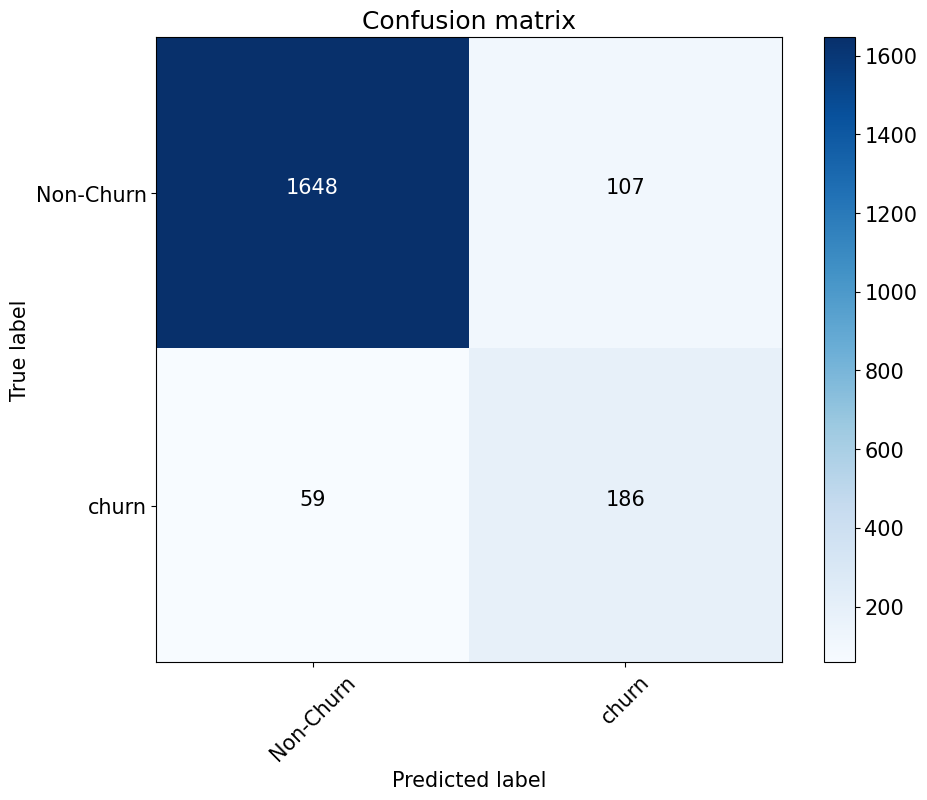

In [36]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [37]:
roc_auc_score(y_test, preds)

0.9530554101982673

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Отредактируем функцию get_user_embedding

In [38]:
def get_user_embedding(user_articles_list, vector_type='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if vector_type == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif vector_type == 'median':
        user_vector = np.median(user_vector, 0)
    elif vector_type == 'max':
        user_vector = np.max(user_vector, 0)
        
    return user_vector

## Используем медианау

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [39]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'median'), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.027964,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.182822,0.0,0.0,0.0,0.133691,0.0,0.204300,0.0,0.00000
1,u108690,0.020974,0.0,0.000000,0.000000,0.0,0.0,0.0,0.007559,0.0,...,0.0,0.072373,0.0,0.0,0.0,0.031763,0.0,0.351904,0.0,0.11848
2,u108339,0.045767,0.0,0.008374,0.012975,0.0,0.0,0.0,0.025689,0.0,...,0.0,0.270305,0.0,0.0,0.0,0.057077,0.0,0.231331,0.0,0.00000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [40]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [41]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.027964,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.182822,0.0,0.0,0.0,0.133691,0.0,0.204300,0.0,0.00000,0
1,u108690,0.020974,0.0,0.000000,0.000000,0.0,0.0,0.0,0.007559,0.0,...,0.072373,0.0,0.0,0.0,0.031763,0.0,0.351904,0.0,0.11848,1
2,u108339,0.045767,0.0,0.008374,0.012975,0.0,0.0,0.0,0.025689,0.0,...,0.270305,0.0,0.0,0.0,0.057077,0.0,0.231331,0.0,0.00000,1


In [42]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [43]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [44]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.15133862, 0.11464326, 0.52466085, 0.54514024, 0.04042303,
       0.06949603, 0.35595619, 0.03904121, 0.32276747, 0.10277528])

### Рассчитаем Precision, Recall, F_score

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.260183, F-Score=0.749, Precision=0.684, Recall=0.829


Confusion matrix, without normalization
[[1661   94]
 [  43  202]]


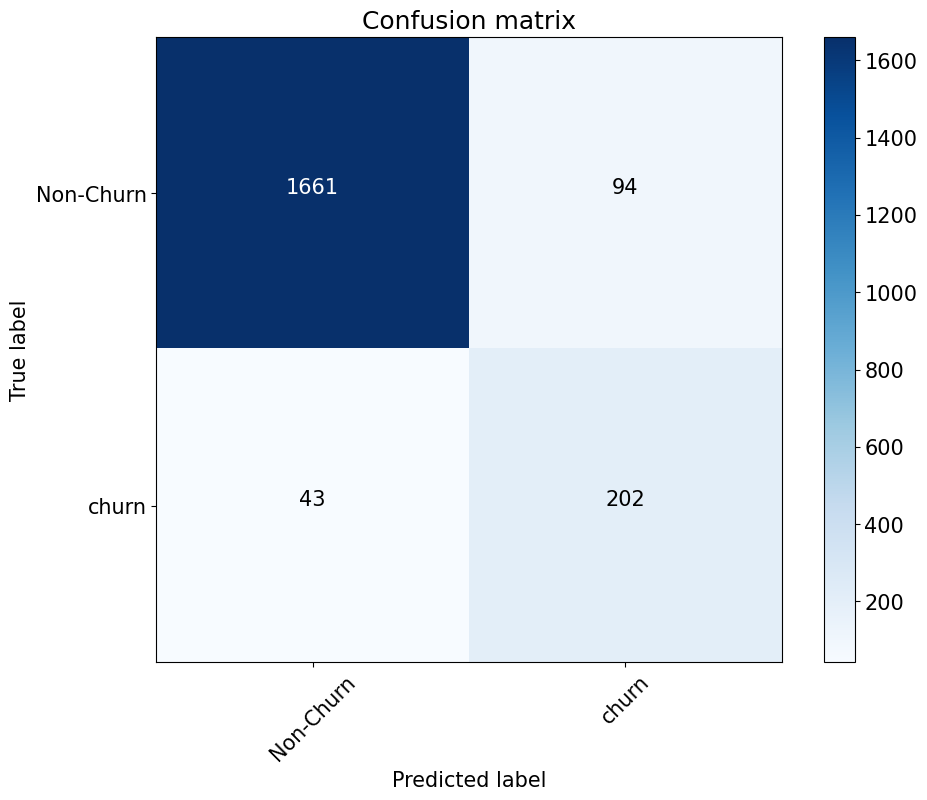

In [46]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [47]:
roc_auc_score(y_test, preds)

0.9636746322460608

#### При использовании медианы всместо среднегоROC AUC и метрики качества изменились в лучшую сторону.

## Используем мах

In [48]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'max'), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.135240,0.024237,0.043035,0.014464,0.012614,0.090440,0.000000,0.090279,0.0,...,0.096441,0.497047,0.0,0.0,0.091341,0.258999,0.000000,0.506922,0.080498,0.090134
1,u108690,0.132862,0.025164,0.000000,0.000000,0.000000,0.029516,0.015153,0.056257,0.0,...,0.000000,0.454021,0.0,0.0,0.012557,0.107677,0.019655,0.553975,0.012557,0.162484
2,u108339,0.088469,0.028468,0.073105,0.037791,0.000000,0.024151,0.000000,0.116726,0.0,...,0.016594,0.383965,0.0,0.0,0.000000,0.121396,0.013474,0.356760,0.014701,0.032729


In [49]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.135240,0.024237,0.043035,0.014464,0.012614,0.090440,0.000000,0.090279,0.0,...,0.497047,0.0,0.0,0.091341,0.258999,0.000000,0.506922,0.080498,0.090134,0
1,u108690,0.132862,0.025164,0.000000,0.000000,0.000000,0.029516,0.015153,0.056257,0.0,...,0.454021,0.0,0.0,0.012557,0.107677,0.019655,0.553975,0.012557,0.162484,1
2,u108339,0.088469,0.028468,0.073105,0.037791,0.000000,0.024151,0.000000,0.116726,0.0,...,0.383965,0.0,0.0,0.000000,0.121396,0.013474,0.356760,0.014701,0.032729,1


In [50]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [51]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [52]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([7.22011412e-02, 4.09041950e-04, 6.54256436e-01, 1.20970432e-01,
       9.82709243e-02, 5.44418887e-02, 3.41200271e-01, 6.02225548e-02,
       7.89861052e-02, 2.77333645e-01])

### Рассчитаем Precision, Recall, F_score

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.368559, F-Score=0.719, Precision=0.793, Recall=0.657


#### F-score, Precision и recall теперь имеют значения отличные от нуля, но при это значения неплохие > 83%

Confusion matrix, without normalization
[[1713   42]
 [  85  160]]


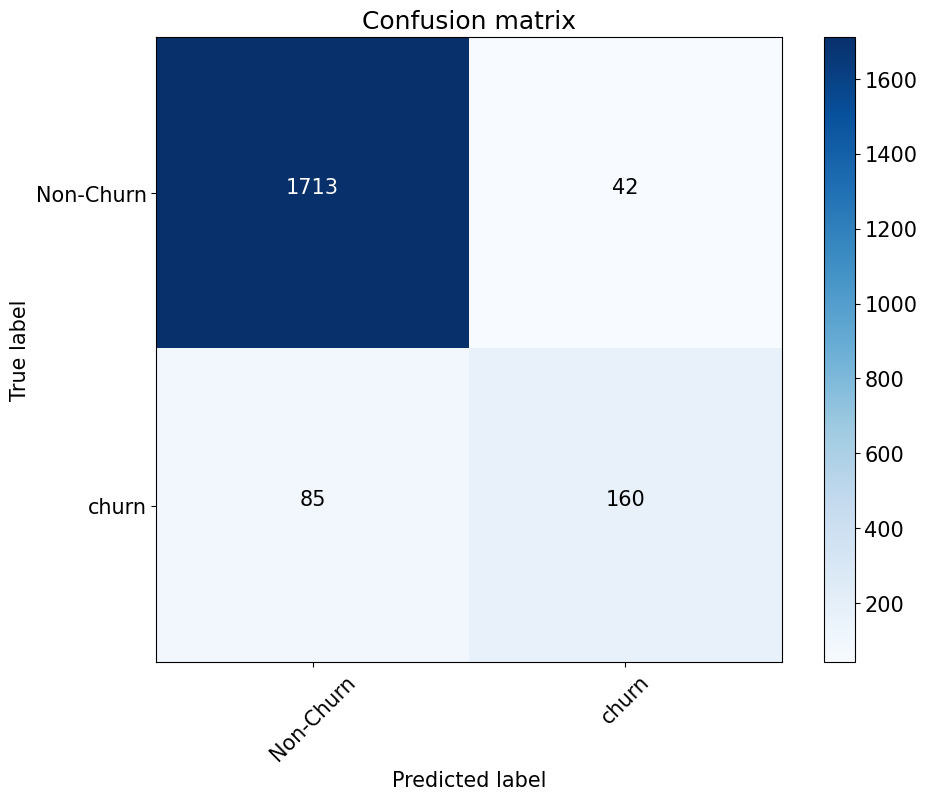

In [54]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [55]:
roc_auc_score(y_test, preds)

0.9521762893191463

#### По результатам проведеных изменнеий наилучший варриант метрик ROC AUC F-score, Precision и Recall дает использование медианы.